In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

rng = np.random.default_rng(18)

In [2]:
class WaveSpectrum:
    
    def __init__(self, Hs, T2):
        self.Hs = Hs
        self.T2 = T2

    def eval(self, w):
        raise NotImplementedError("Evaluation method not implemented")

    def generate_random_wave(
        self,
        x=0.0,
        frequency_range=(0.2, 3.2),
        number_of_components=1000,
        total_time=10800,
        time_step = 0.1,
    ):
        xa = np.asarray(x)[np.newaxis].T
        we = np.linspace(*frequency_range, number_of_components+1)
        dw = (frequency_range[1] - frequency_range[0])/number_of_components
        
        nt = np.ceil(total_time/time_step).astype(int) + 1
        t = np.linspace(0.0, total_time, nt)[np.newaxis, :]
        z = np.zeros((xa.size, t.size))
        
        for i in range(number_of_components):
            w1, w2 = we[i:i+2]
            w = w1 + dw * rng.random()
            k = w**2/9.81
            s = self.eval(w)
            a = np.sqrt(2*s*dw)
            e = 2*np.pi * rng.random()
            z += a * np.sin(w*t - k*xa + e)
        
        return t.squeeze(), z.squeeze()

    def plot_realization(
        self,
        frequency_range=(0.2, 3.2),
        number_of_components=1000,
        total_time=100,
        time_step = 0.1,
        save_figure=False,
    ):
        x0 = 0.0
        t, z = self.generate_random_wave(
            x = x0,
            frequency_range = frequency_range,
            number_of_components=number_of_components,
            total_time=total_time,
            time_step=time_step,
        )

        fig, ax = plt.subplots(figsize=(5,3))
        ax.set_title(f'Time series at $x$={x0:.1f}, $H_s$ = {self.Hs:.1f}, $T_2$ = {self.T2:.1f}')
        ax.set_xlabel('t (s)')
        ax.set_ylabel(r'$\zeta$ (m)')
        ax.plot(t, z, '-b')

        if save_figure:
            fig.savefig(f'ts_h{self.Hs:.0f}_t{self.T2:.0f}.svg', bbox_inches='tight')

        plt.show()
    
    def plot_spectrum(
        self,
        frequency_range=(0.0, 3.0),
        number_of_points=100,
        save_figure=False
    ):
        w = np.linspace(*frequency_range, number_of_points)
        s = self.eval(w)
        
        name = self.__class__.__name__
        w0 = 0.5*w*self.T0/np.pi
        s0 = s/(self.Hs**2 * self.T0)
        
        fig, ax = plt.subplots(figsize=(5,3))
        ax.set_title(f'{name} Wave Spectrum, $H_s$ = {self.Hs:.1f}, $T_2$ = {self.T2:.1f}')
        ax.set_xlabel(r'$\frac{\omega T_2}{2 \pi}$', fontsize=14)
        ax.set_ylabel(r'$\frac{S(\omega)}{H_s^2 T_2}$', fontsize=14, rotation=0.0, labelpad=20)

        ax.plot(w0, s0, '-k')

        if save_figure:
            fig.savefig(f'{name}_H{self.Hs:.0f}_T{self.T2:.0f}.svg'.lower(), bbox_inches='tight')
        
        plt.show()

    def animate_random_wave(self, xrange=(0.0, 50.0), nx=100, total_time=60, dt=0.2):
        x = np.linspace(*xrange, nx)
        
        t, z = self.generate_random_wave(
            x = x,
            total_time=total_time,
            time_step=dt,
        )

        zmin = 1.1 * z.min()
        zmax = 1.1 * z.max()
        
        def irregular_wave(i):
            xverts = np.concatenate((x, x[::-1]))
            yverts = np.concatenate((zmin*np.ones(x.shape), z[::-1,i]))
            verts = np.vstack((xverts, yverts)).T
            water_fill.set_verts([verts])
            wave_profile.set_data(x, z[:, i])
            ax.set_title(rf'$\zeta$ (t = {t[i]:.1f} s)')
        
            return wave_profile, water_fill
        
        fig, ax = plt.subplots(figsize=(7,5))
        ax.axis('off')
        ax.margins(0)
        ax.set_aspect('equal')
        ax.set_ylim(zmin, zmax)
        wave_profile, = ax.plot([], [])
        water_fill = ax.fill_between(x, zmin, zmax, color='b', alpha=0.4)

        anim = FuncAnimation(fig, irregular_wave, frames=len(t), interval=100, blit=True) 
        writer = FFMpegWriter(fps=10)
        anim.save('irregular_wave.gif', writer=writer, dpi=100)


class ISSC(WaveSpectrum):

    def __init__(self, Hs, T2):
        super().__init__(Hs, T2)
        self.T1 = 1.086*T2
        self.T0 = 1.408*T2
    
    def eval(self, w):
        wa = np.asarray(w)
        pmask = wa > 0.0
        wp = wa[pmask]
        s = np.zeros_like(wa)
        
        tw = 2.0*np.pi / (wp*self.T1)
        tw4 = tw**4
        tw5 = tw4 * tw
        th = self.Hs**2 * self.T1
        s[pmask] = th * 0.055/np.pi * tw5 * np.exp(-0.44 * tw4)

        return s

In [3]:
wave_spectrum = ISSC(8.0, 10.0)

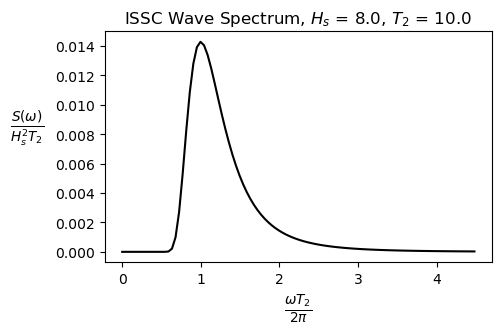

In [4]:
wave_spectrum.plot_spectrum(frequency_range=(0.0, 2.0), save_figure=True)

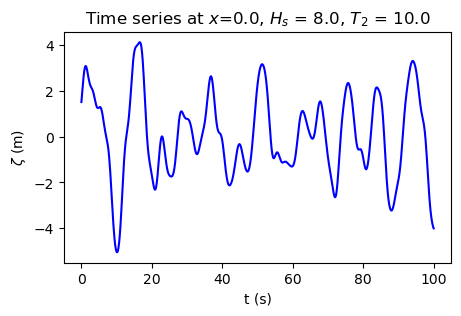

In [5]:
wave_spectrum.plot_realization(save_figure=True)

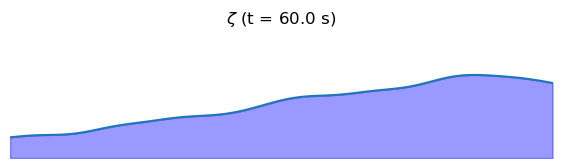

In [6]:
wave_spectrum.animate_random_wave()

In [7]:
import oceanlyz as oc

In [8]:
frequency_range = (0.2, 3.2)
total_time = 10800
time_step = 0.5

_, wave_elevation = wave_spectrum.generate_random_wave(
    frequency_range=frequency_range,
    total_time=total_time,
    time_step=time_step,
)

In [9]:
ocn = oc.oceanlyz()
ocn.data = wave_elevation

ocn.InputType='waterlevel'
ocn.OutputType='wave'
ocn.AnalysisMethod='spectral'
ocn.n_burst=1
ocn.burst_duration=total_time
ocn.fs=int(1/time_step)
ocn.fmin=frequency_range[0]/(2*np.pi)
ocn.fmax=frequency_range[1]/(2*np.pi)

ocn.runoceanlyz()

--------------------------------------------------
OCEANLYZ Ver 2.0
www.ArashKarimpour.com
Copyright (C) 2012 - 2026  Arash Karimpour
--------------------------------------------------
Parameters (only required ones used)
--------------------------------------------------
InputType           :  waterlevel
OutputType          :  wave
-------------------------------
AnalysisMethod      :  spectral
-------------------------------
n_burst             :  1
burst_duration      :  10800
fs                  :  2
-------------------------------
fmin                :  0.03183098861837907
fmax                :  0.5092958178940651
-------------------------------
fmaxpcorrCalcMethod :  auto
Kpafterfmaxpcorr    :  constant
fminpcorr           :  0.15
fmaxpcorr           :  0.55
heightfrombed       :  0.0
-------------------------------
dispout             :  no
-------------------------------
Rho                 :  1000
nfft                :  512
-------------------------------
SeparateSeaSwell    :

In [10]:
ocn_hs = ocn.wave['Hm0'].squeeze()
ocn_t0 = ocn.wave['Tp'].squeeze()
ocn_w = 2*np.pi * ocn.wave['f'].squeeze()
ocn_s = ocn.wave['Syy'].squeeze() / (2*np.pi)

print(f'Hs = {ocn_hs}')
print(f'T0 = {ocn_t0}')
print(f'T2 = {ocn_t0/1.408}')

wmax = 2.0
w_mask = ocn_w < wmax
ocn_wm = ocn_w[w_mask]
ocn_sm = ocn_s[w_mask]

Hs = 7.936609032161536
T0 = 14.222222222222221
T2 = 10.1010101010101


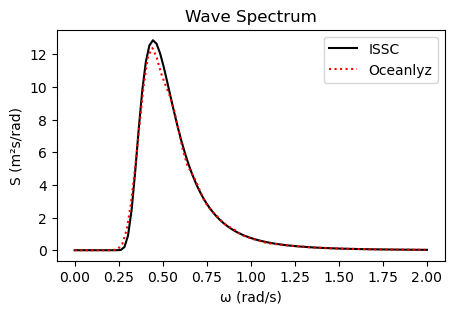

In [11]:
w = np.linspace(0.0, wmax, 100)
s = wave_spectrum.eval(w)

fig, ax = plt.subplots(figsize=(5,3))
ax.set_title(f'Wave Spectrum')
ax.set_xlabel(r'ω (rad/s)')
ax.set_ylabel(r'S (m²s/rad)')

ax.plot(w, s, '-k', label='ISSC')
ax.plot(ocn_wm, ocn_sm, ':r', label='Oceanlyz')

ax.legend()

fig.savefig(f'wave_spectrum.svg', bbox_inches='tight')

plt.show()